In [24]:
# Import libraries
from pyspark.sql import SparkSession
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from medmnist import INFO, ChestMNIST
# medmnist is a library that allows us to use medical images. In this case we are using
# chest x-rays of people with pneumonia
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize


In [25]:
 # Initialize Spark session
spark = SparkSession.builder \
    .appName("Final Project Team 19") \
    .getOrCreate()

In [26]:
# Choose chest x-ray data from medmnist library
data_flag = 'chestmnist'
info = INFO[data_flag]

In [27]:
# Load the dataset using MedMNIST library
train_dataset = ChestMNIST(split='train', download=True)
val_dataset = ChestMNIST(split='val', download=True)
test_dataset = ChestMNIST(split='test', download=True)

Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz


In [28]:
# Extract the pixel data
X_train, X_val, X_test = train_dataset.imgs, val_dataset.imgs, test_dataset.imgs

In [29]:
# ** Data Exploration **
# Methods used below:
#    1) Normalization
#    2) Conversion of multi-label data to binary labels

In [30]:
# Convert multi-label data to binary (0 or 1)
def convert2Binary(labels):
    return np.where(labels.sum(axis=1) > 0, 1, 0)

In [31]:
# Apply binary conversion to labels
y_train = convert2Binary(train_dataset.labels)
y_val = convert2Binary(val_dataset.labels)
y_test = convert2Binary(test_dataset.labels)

In [32]:
# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [33]:
# Add another dimension for CNN model to be able to process the data. 
# Now the image shape is (28,28,1)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [34]:
# ** Data Preparation and Feature Engineering **
# Method used below:
#    1) Rebalancing dataset to match size of negative class to positive class
#    2) Visualization of data post rebalancing to verify that data really is balanced

In [35]:
# Helper function to rebalance the Dataset (Over-sampling minority class)
def rebalance_data(X, y):
    # filter the data based on negative and positive values
    X_negative = X[y == 0]
    y_negative = y[y == 0]
    X_positive = X[y == 1]
    y_positive = y[y == 1]

    # Over-sample positive class
    X_positive_oversampled, y_positive_oversampled = resample(
        X_positive, y_positive,
        replace=True,
        n_samples=len(y_negative),
        random_state=42
    )

    # Combine oversampled positive and negative samples. This creates a rebalanced feature set and label set
    X_balanced = np.vstack((X_negative, X_positive_oversampled))
    y_balanced = np.hstack((y_negative, y_positive_oversampled))

    # Shuffle the dataset to make sure there is no chance of accidentally ordered data.
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    return X_balanced[indices], y_balanced[indices]


In [36]:
# Apply hepler function to rebalance training data
X_train_balanced, y_train_balanced = rebalance_data(X_train, y_train)

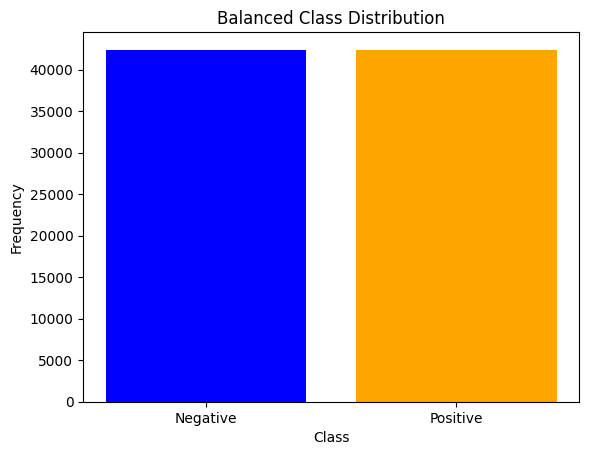

In [37]:
# Visualize Class Distribution
def plot_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique, ['Negative', 'Positive'])
    plt.show()

plot_class_distribution(y_train_balanced, title="Balanced Class Distribution")


In [38]:
# ** Machine Learning Prep and Tuning
# Methods used below:
#    1) CNN model build

In [39]:
# Define the CNN model using keras
# This contains two convolutional layers with ReLU activiation
# Dimentionality reduction via MaxPooling
# normalizations and stabalization via BatchNormalization
# prevention of overfitting via dense and dropout laters
# binary classification via the sigmoid function
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

C:\Users\areeb\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Use Adam optimizer and binary cross-entropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Train the Model using Keras on 20 epochs. We are using batch sized of 32
history = model.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.6099 - loss: 0.6818 - val_accuracy: 0.6439 - val_loss: 0.6372
Epoch 2/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6437 - loss: 0.6438 - val_accuracy: 0.6395 - val_loss: 0.6592
Epoch 3/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6561 - loss: 0.6336 - val_accuracy: 0.6435 - val_loss: 0.6425
Epoch 4/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.6640 - loss: 0.6252 - val_accuracy: 0.6211 - val_loss: 0.6567
Epoch 5/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6667 - loss: 0.6224 - val_accuracy: 0.6626 - val_loss: 0.6296
Epoch 6/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.6748 - loss: 0.6134 - val_accuracy: 0.5684 - val_loss: 1.0998
Epoch 7/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6775 - loss: 0.6073 - val_accuracy: 0.5689 - val_loss: 0.6884
Epoch 8/100
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 

In [42]:
# Model Evaluation and Visualization:
# Methods used:
#    1) Confusion Matrix
#    2) Classfication Report
#    3) Training history visualization

In [43]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.64


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


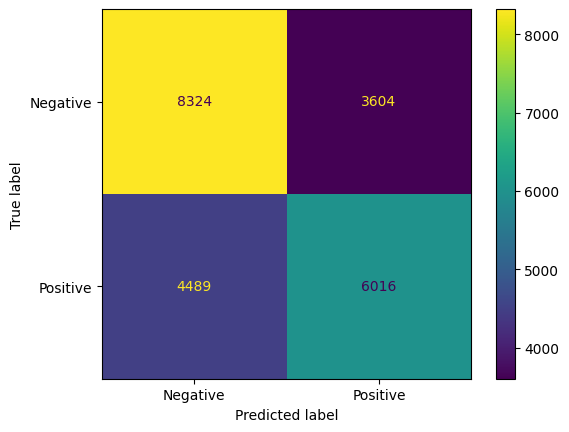

In [44]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative', 'Positive'])
plt.show()

In [45]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.70      0.67     11928
    Positive       0.63      0.57      0.60     10505

    accuracy                           0.64     22433
   macro avg       0.64      0.64      0.64     22433
weighted avg       0.64      0.64      0.64     22433



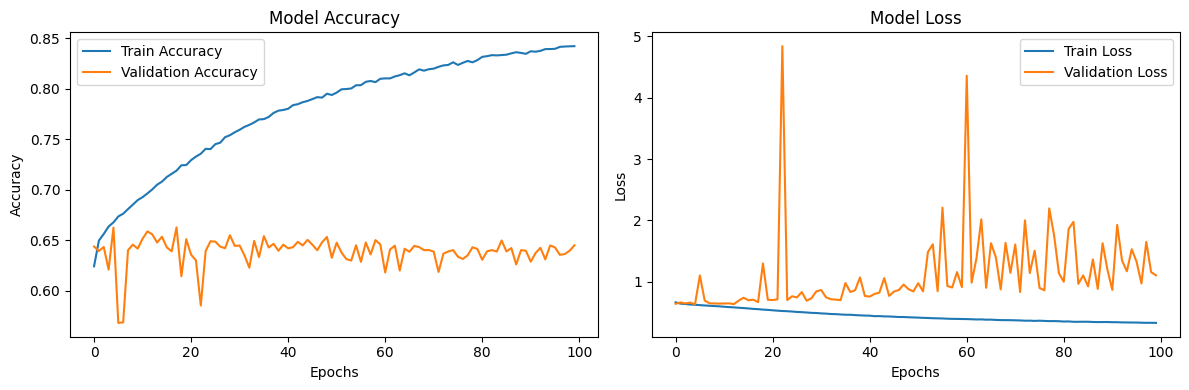

In [46]:
# Plot accuracy and loss over the epochs to view models performane through time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Limitations, Future Work, and Conclusion
# Limitations:
#     1) The class balance even after over-sampling may still have been severly imbalanced
#     2) The quality and resolution of the images may not have been fine-grained enough
#     3) Real world diagnosis are more complex than binary classifications

# Future Work:
#     1) Use multi-class classification instead of binary
#     2) increase image resolution for better feature extraction.


In [48]:
# Overall Performance
# The CNN model was able to classify these chest x-ray images with decent accuracy but there are still areas for improvement
# We included the appropriate preprocessing steps, model tuning and evaluation 

# We tried multiple approaches and tuning abilites. This is our final approach with the best accuracy we could get. 